In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import Dict, List, Tuple, Optional, Callable
from dataclasses import dataclass
import warnings
warnings.filterwarnings("ignore")

In [3]:
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (14, 8)


In [37]:
@dataclass
class Shot:
    name: str
    base_run_prob: float
    aggression: float
    aerial_risk: float
    gap_finding: float

class CricketMDPEnvironment:
    def __init__(self, seed: Optional[int] = 42):
        np.random.seed(seed)
        self.shots = [
            Shot('defensive push', 0.85, 0.0, 0.00, 0.90),
            Shot('cover drive', 0.91, 0.89, 0.15, 0.90),
            Shot('straight drive', 0.68, 0.4, 0.20, 0.75),
            Shot('lofted off drive', 0.55, 0.7, 0.60, 0.50),
            Shot('pull/hook', 0.50, 0.8, 0.70, 0.45),
            Shot('sweep', 0.40, 0.95, 0.85, 0.30),
            Shot('scoop', 0.35, 1.0, 0.90, 0.25),
            Shot('reverse sweep', 0.88, 0.7, 0.80, 0.35)
        ]
        self.n_arms = len(self.shots)
        self.max_wickets = 10
        self.max_balls = 60
        self.momentum = 0
        self.momentum_decay = 0.9

    def _pressure_factor(self, wickets_left: int) -> float:
        return 1.0 + (10 - wickets_left) * 0.12

    def _field_placement_multiplier(self, shot: Shot, wickets_left: int) -> float:
        aggressive_shots = wickets_left <= 4
        if aggressive_shots and shot.aggression > 0.7:
            return 0.88
        return 1.0

    def pull(self, arm_idx: int, wickets_left: int, balls_left: int) -> Tuple[int, bool, Dict]:
        shot = self.shots[arm_idx]
        pressure = self._pressure_factor(wickets_left)
        field_mult = self._field_placement_multiplier(shot, wickets_left)
        momentum_bonus = 1.0 + self.momentum * 0.4

        success_prob = (shot.base_run_prob * field_mult * momentum_bonus / (pressure ** (shot.aggression ** 0.5)))
        success_prob = np.clip(success_prob, 0.05, 0.99)

        if np.random.rand() > success_prob:
            self.momentum = max(-3, self.momentum - 2)
            return 0, True, {'type': 'wicket', 'shot': shot.name}
        
        if shot.aggression < 0.3:
            runs = np.random.choice([0, 1, 2], p=[0.4, 0.5, 0.1])
        elif shot.aggression < 0.7:
            runs = np.random.choice([0, 1, 2, 3, 4], p=[0.1, 0.3, 0.3, 0.2, 0.1])
        else:
            runs = np.random.choice([0, 1, 2, 4, 6], p=[0.15, 0.15, 0.2, 0.3, 0.2])

        if runs >= 4:
            self.momentum = min(3, self.momentum + 1)
        elif runs == 0:
            self.momentum = max(-3, self.momentum - 0.5)
        self.momentum *= self.momentum_decay
        return runs, False, {"type": "runs", "runs": runs, "shot": shot.name}

## UCB1 Algorithm — Math Formulas

### Empirical Mean Update

$$
\hat{\mu}_i \leftarrow \hat{\mu}_i + \frac{r_t - \hat{\mu}_i}{N_i}
$$

---

### UCB1 Selection Rule

$$
i_t = \arg\max_i 
\left( 
\hat{\mu}_i(t) + 
c \sqrt{\frac{\ln(t)}{N_i(t)}}
\right)
$$

---

### Initialization

$$
i_t = t - 1 \quad \text{for } t = 1, \ldots, K
$$

---

### Final UCB Formula

$$
\text{UCB}_i(t) 
= 
\hat{\mu}_i(t) 
+ 
c \sqrt{\frac{\ln(t)}{N_i(t)}}
$$


In [38]:
class UCB1:
    def __init__(self, n_arms: int, c: float = 2.0):
        self.n_arms = n_arms
        self.c = c
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.t = 0

    def select_arm(self) -> int:
        self.t += 1
        if self.t <= self.n_arms:
            return (self.t - 1) % self.n_arms
        ucb = self.values + self.c * np.sqrt(np.log(self.t) / (self.counts + 1e-6))
        return int(np.argmax(ucb))

    def update(self, arm: int, reward: float):
        self.counts[arm] += 1
        n = self.counts[arm]
        self.values[arm] += (reward - self.values[arm])

## Thompson Sampling Math

### Beta Prior
For each arm \(i\):

$$
\theta_i \sim \text{Beta}(\alpha_i, \beta_i)
$$

---

### Arm Selection

Sample from each posterior:

$$
\tilde{\theta}_i \sim \text{Beta}(\alpha_i, \beta_i)
$$

Choose the arm:

$$
A_t = \arg\max_i \tilde{\theta}_i
$$

---

### Posterior Update

Given reward \(r\) for arm \(A_t\):

$$
\alpha_{A_t} \leftarrow \alpha_{A_t} + r
$$

$$
\beta_{A_t} \leftarrow \beta_{A_t} + (5 - r)
$$


In [39]:
class ThompsonSampling:
    def __init__(self, n_arms: int, alpha: float = 1.0, beta: float = 1.0):
        self.alpha = np.ones(n_arms) * alpha
        self.beta = np.ones(n_arms) * beta

    def select_arm(self) -> int:
        samples = np.random.beta(self.alpha, self.beta)
        return int(np.argmax(samples))

    def update(self, arm: int, reward: float):
        if reward > 0:
            self.alpha[arm] += reward
        self.beta[arm] += (5 - reward)

## LinUCB (Contextual Bandit) — Mathematical Formulation

### Context Vector
At each timestep, we observe a context vector:

$$
x_t \in \mathbb{R}^d
$$




### Per-Arm Parameters

For each arm \( a \in \{1, \dots, K\} \), LinUCB maintains:

- a matrix  
  $$
  A_a \in \mathbb{R}^{d \times d}
  $$
- a vector  
  $$
  b_a \in \mathbb{R}^{d \times 1}
  $$

These are used to estimate:

$$
\theta_a = A_a^{-1} b_a
$$

---

### Arm Selection Rule (UCB)

Given a context \(x_t\), predict reward mean:

$$
\mu_a = \theta_a^\top x_t
$$

Compute uncertainty:

$$
\sigma_a = \sqrt{x_t^\top A_a^{-1} x_t}
$$

Upper Confidence Bound:

$$
\text{UCB}_a = \mu_a + \alpha \, \sigma_a
$$

Choose arm:

$$
A_t = \arg\max_a \text{UCB}_a
$$

---

### Parameter Update

After selecting arm \(A_t\) and receiving reward \(r_t\):

$$
A_{A_t} \leftarrow A_{A_t} + x_t x_t^\top
$$

$$
b_{A_t} \leftarrow b_{A_t} + r_t x_t
$$


In [40]:
class LinUCBContextual:
    def __init__(self, n_arms: int, context_dim: int = 5, alpha: float = 1.5):
        self.alpha = alpha
        self.n_arms = n_arms
        self.A = [np.eye(context_dim) for _ in range(n_arms)]
        self.b = [np.zeros((context_dim, 1)) for _ in range(n_arms)]

    def select_arm(self, context: np.ndarray) -> int:
        context = context.reshape(-1, 1)
        ucb_values = []
        for a in range(self.n_arms):
            A_inv = np.linalg.inv(self.A[a])
            theta = A_inv @ self.b[a]
            mean = theta.T @ context
            var = np.sqrt(context.T @ A_inv @ context)
            ucb_values.append(mean + self.alpha * var)
        return int(np.argmax(ucb_values))

    def update(self, arm: int, reward: float, context: np.ndarray):
        context = context.reshape(-1, 1)
        self.A[arm] += context @ context.T
        self.b[arm] += reward * context


## Neural Contextual Bandit — Mathematical Formulation

### Model
We use a 1-hidden-layer neural network to estimate Q-values for each arm.

Given context vector \( x \in \mathbb{R}^d \):

Hidden layer:

$$
h = \text{ReLU}(x W_1)
$$

Output (Q-values):

$$
Q = h W_2
$$

Arm selection:

$$
A_t = \arg\max_a \left( Q_a + \epsilon \right)
$$

where \( \epsilon \sim \mathcal{N}(0, 0.1) \) adds exploration noise.

---

### Training (Stochastic Gradient Descent)

For each stored (context, arm, reward) sample:

1. **Forward pass**

Hidden:

$$
h = \text{ReLU}(x W_1)
$$

Prediction for chosen arm \( a \):

$$
\hat{r} = Q_a = h W_{2[:,a]}
$$

2. **Error**

$$
e = r - \hat{r}
$$

3. **Gradients**

Gradient w.r.t. second layer:

$$
\nabla W_{2[:,a]} = -e \, h
$$

Backprop into hidden layer:

$$
\nabla h = -e \, W_{2[:,a]}
$$

Apply ReLU derivative:

$$
\nabla h_{\text{relu}} = \nabla h \odot \mathbf{1}_{(h > 0)}
$$

Gradient w.r.t. first layer:

$$
\nabla W_1 = - x^\top \nabla h_{\text{relu}}
$$

4. **Parameter updates**

With learning rate \( \eta = 0.001 \):

$$
W_2 \leftarrow W_2 - \eta \nabla W_2
$$

$$
W_1 \leftarrow W_1 - \eta \nabla W_1
$$

---

### Summary
- A neural network approximates Q-values for each arm.  
- Exploration is added through Gaussian noise.  
- A replay buffer of size ≥ 500 triggers training.  
- Training uses batch SGD and ReLU backprop.



In [41]:
class NeuralContextualBandit:
    def __init__(self, n_arms: int, hidden: int = 64):
        self.n_arms = n_arms
        self.W1 = np.random.randn(5, hidden) * 0.01
        self.W2 = np.random.randn(hidden, n_arms) * 0.01
        self.history = []
    
    def _relu(self, x):
        return np.maximum(0, x)
    
    def select_arm(self, context: np.ndarray) -> int:
        h = self._relu(context @ self.W1)
        q_values = h @ self.W2
        return int(np.argmax(q_values + np.random.randn(self.n_arms) * 0.1))
    
    def update(self, arm: int, reward: float, context: np.ndarray):
        self.history.append((context.copy(), arm, reward))
        if len(self.history) > 500:
            self._train_step()
    
    def _train_step(self):
        np.random.shuffle(self.history)
        batch = self.history[:256]
        for ctx, a, r in batch:
            h = self._relu(ctx @ self.W1)
            pred = h @ self.W2
            error = r - pred[a]
            grad_W2 = -error * h.reshape(-1, 1)
            grad_h = -error * self.W2[:, a:a+1].T
            grad_W1 = -np.outer(ctx, (h > 0) * grad_h)
            self.W2 -= 0.001 * grad_W2
            self.W1 -= 0.001 * grad_W1


In [42]:
def run_innings(agent_class, **kwargs) -> Dict:
    env = CricketMDPEnvironment()
    if 'UCB' in str(agent_class):
        agent = agent_class(n_arms=env.n_arms, **kwargs)
    elif 'Thompson' in str(agent_class):
        agent = agent_class(n_arms=env.n_arms, **kwargs)
    elif 'Neural' in str(agent_class):
        agent = agent_class(n_arms=env.n_arms, **kwargs)
    else:
        agent = agent_class(n_arms=env.n_arms, **kwargs)
    
    total_runs = 0
    wickets = 10
    balls = 60
    history = []
    regrets = []

    oracle_scores = []
    for w in range(0, 11):
        best = 0
        for arm in range(env.n_arms):
            shot = env.shots[arm]
            ev = shot.base_run_prob * 3.5 * (1 + 0.1 * w / 10) - (1 - shot.base_run_prob) * 40
            best = max(best, ev)
        oracle_scores.append(best * min(60, 60 // (11 - w)))

    while balls > 0 and wickets > 0:
        pressure = env._pressure_factor(wickets)
        context = np.array([
            wickets / 10.0,
            balls / 60.0,
            pressure,
            env.momentum / 3.0,
            len(history) / 60.0
        ])

        if isinstance(agent, (LinUCBContextual, NeuralContextualBandit)):
            arm = agent.select_arm(context)
        else:
            arm = agent.select_arm()

        runs, wicket, info = env.pull(arm, wickets, balls)
        reward = runs if not wicket else -5

        total_runs += runs
        if wicket:
            wickets -= 1

        if isinstance(agent, (LinUCBContextual, NeuralContextualBandit)):
            agent.update(arm, reward, context)
        else:
            agent.update(arm, reward)

        optimal_per_ball = oracle_scores[10 - wickets] / 60
        cumulative_optimal = (60 - balls) * optimal_per_ball
        regret = cumulative_optimal - total_runs
        regrets.append(regret)

        history.append({
            "ball": 60 - balls + 1,
            "shot": env.shots[arm].name,
            "runs": runs,
            "wicket": wicket,
            "wickets_left": wickets,
            "total_runs": total_runs,
            "regret": regret
        })
        balls -= 1

    return {
        "runs": total_runs,
        "regrets": regrets,
        "history": pd.DataFrame(history),
        "agent": agent,
        "name": agent_class.__name__
    }

simulating UCB1
26 runs | final regret: -26.0

simulating ThompsonSampling
0 runs | final regret: 0.0

simulating LinUCBContextual
47 runs | final regret: -47.0

simulating NeuralContextualBandit
0 runs | final regret: 0.0



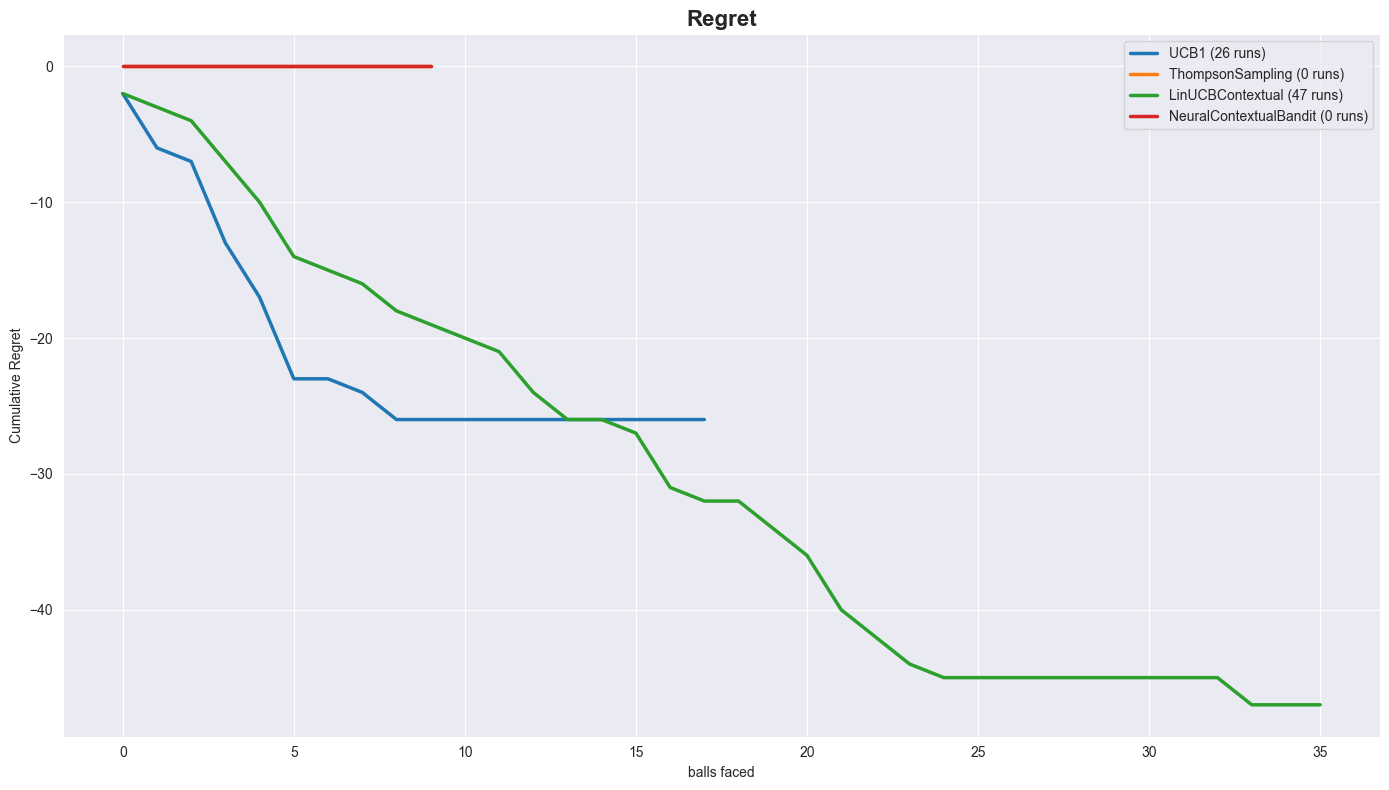


best is: LinUCBContextual
shot dis:
shot
straight drive      24
defensive push       4
cover drive          2
reverse sweep        2
lofted off drive     1
pull/hook            1
sweep                1
scoop                1
Name: count, dtype: int64


In [43]:
if __name__ == "__main__":
    np.random.seed(42)
    results = {}

    for agent_class, params in [
        (UCB1, {'c': 1.4}),
        (ThompsonSampling, {}),
        (LinUCBContextual, {'alpha': 1.2}),
        (NeuralContextualBandit, {})]:
        print(f'simulating {agent_class.__name__}')
        result = run_innings(agent_class, **params)
        results[result["name"]] = result
        print(f"{result['runs']} runs | final regret: {result['regrets'][-1]:.1f}\n")

    plt.figure()
    for name, res in results.items():
        plt.plot(res["regrets"], label=f"{name} ({res['runs']} runs)", linewidth=2.5)
    plt.title("Regret", fontsize=16, fontweight='bold')
    plt.xlabel("balls faced")
    plt.ylabel("Cumulative Regret")
    plt.legend()
    plt.tight_layout()
    plt.savefig("cricket_regret.png", dpi=300)
    plt.show()

    best_agent = max(results.values(), key=lambda x: x["runs"])
    counts = best_agent["history"]["shot"].value_counts()
    print("\nbest is:", best_agent["name"])
    print("shot dis:")
    print(counts)